# Figure 3 Inference over three-parameter DSO wiring rule

This notebook contains the Python code for generating Figure 3 in the paper. 
The figure shows the results for performing SBI over the three parameters of the DSO wiring rule, given seven connectivity measurements from thalamus to barrel cortex. 

The training data and inference objects are pre computed and only loaded for visualization in this notebook.
The following results are loaded: 
- SBI object, simulator, prior, posterior for inference given observed data
- posterior predictive checks: simulated data from samples from the posterior. 
- cross validation results: predictive samples from each of seven posteriors, where each posterior estimate was trained on only six of the seven measurements. 

For details on how to perform inference, see `/tutorials` or `/scripts`


In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import numpy as np
import pickle
import sys
import torch

sys.path.append("../")
from plotting_utils import custom_marginal_plot

from sbi.simulators import simulate_in_batches
from sbi.inference import prepare_for_sbi
from sbi.analysis import pairplot, conditional_pairplot
from sbi.inference import SNPE

from consbi import DATA_PATH, RESULTS_PATH

plt.style.use('../plotting_settings.mplstyle')
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load literature inference results
with open(RESULTS_PATH.joinpath("npe_dso_gaussian_05_n500000r2x100k.p"), "rb") as fh:
    prior, estimator, posteriors, thos, xos, kwargs, seed = pickle.load(fh).values()
    
with open(DATA_PATH.joinpath("presimulated_dso_gaussian_05_n500000.p"), "rb") as fh:
    prior, ths, xs = pickle.load(fh).values()

posterior = posteriors[-1]

## Generate predictive samples and data

In [3]:
# set observed data values from literature.
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])
posterior.set_default_x(xo)
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]

In [4]:
# NOTE: set True if predictive simulations should be run again (takes some time).
generate_new_results = False

if generate_new_results:

    thos = posterior.sample((N,), x=xo, show_progress_bars=False)
    batch_simulator, prior = prepare_for_sbi(simulator, prior)
    num_workers = 20
    
    # xs = simulate_in_batches(batch_simulator, ths, num_workers=num_workers, sim_batch_size=50)
    xos = simulate_in_batches(batch_simulator, thos, num_workers=num_workers, sim_batch_size=50)
    
    # save posterior predictive samples
    with open("posterior_predictive_samples.p", "wb") as fh: 
        pickle.dump(dict(thos=thos, xos=xos), fh)
else:
    # load samples
    with open("posterior_predictive_samples.p", "rb") as fh: 
        thos, xos = pickle.load(fh).values()
        
    with open(RESULTS_PATH.joinpath("prior_predictive_samples_dso.p"), "rb") as fh: 
        ths, xs = pickle.load(fh).values()

In [5]:
# load cross validation results
with open(RESULTS_PATH.joinpath("cross_validation_results_default_rule.p"), "rb") as fh:
    predictive_samples_lit = pickle.load(fh)["predictive_samples_lit"]
    
# collect predicted xos for each dimension, shape 1000 x 7.
predicted_xos_per_dim = torch.stack([xii[:, ii] for ii, xii in enumerate(predictive_samples_lit)]).T.numpy()

## Figure 4 version Dec 2022
Gaussian prior with scale 0.5, contour marginals

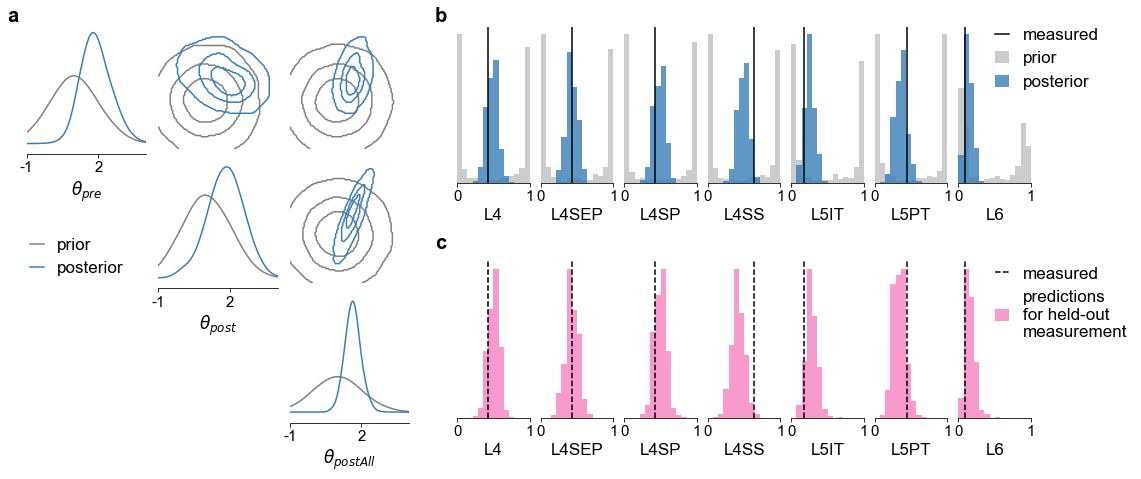

In [6]:
fig = plt.figure(figsize=(18, 7))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.4, .6])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3
handlelength = 0.8

# left column
left_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0.1, hspace=0.1,)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# Posteriors
posterior_opts = dict(upper="contour", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.34, 0.68, 0.95]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      hist_diag=dict(bins=20, histtype="step", density=True),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(-.1, -.6),
           handlelength=handlelength,
           loc=2)


# Posterior predictives
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=.5)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# right_grid = outer_grid[0, 1].subgridspec(2, 7, wspace=0.2, hspace=0.5,)
# ax2 = right_grid.subplots(subplot_kw=dict(sharey=True, sharex=True))


bins = np.linspace(0, 1, 15)
# prior predictive
custom_marginal_plot(ax2, xs.numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,)


plt.sca(ax2[-1])
bbox_to_anchor=(0.3, .5)
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# Cross validation
custom_marginal_plot(ax3, predicted_xos_per_dim, xo, 
                     x_label="predictions\nfor held-out\nmeasurement", 
                     points_label="measured", 
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[3], 
                     handlelength=handlelength,
                     bbox_to_anchor=(0.28, .67), 
                     plot_legend=False,
                     points_line_style="--",
                    )

plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=(0.3, .4), 
           loc="lower left",
          );

# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.46

x1 = 0.11
x2 = 0.44
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "c", fontsize=fontsize, fontweight=weight);

## Posterior Analysis

In [7]:
for end in ["png", "pdf", "eps"]:
    fig.savefig(f"figure3_SBI_results_v5_with_gaussian05_contour.{end}", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
from sbi.utils.metrics import c2st

for ii in range(7):
    print(
        c2st(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1), xos[:1000, ii].reshape(-1, 1))
    )
#     print(np.power(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1) - xos[:1000, ii].reshape(-1, 1), 2).sum())

tensor([0.5410])
tensor([0.5095])
tensor([0.5075])
tensor([0.6485])
tensor([0.5560])
tensor([0.5815])
tensor([0.5175])


In [9]:
xo

array([[0.43, 0.43, 0.42, 0.64, 0.17, 0.44, 0.09]])

In [10]:
predicted_xos_per_dim.mean(0) - xo.squeeze()

array([ 0.06890003, -0.00125998,  0.0732    , -0.22563998,  0.10932   ,
       -0.10447997,  0.07026001])

In [11]:
xos.mean(0) - xo.squeeze()

tensor([ 0.0541, -0.0036,  0.0581, -0.1593,  0.0871, -0.0808,  0.0570],
       dtype=torch.float64)

## Posterior and conditional posterior correlations

In [12]:
# posterior correlations
np.corrcoef(thos, rowvar=False)

array([[ 1.        , -0.3079026 ,  0.29040986],
       [-0.3079026 ,  1.        ,  0.81795337],
       [ 0.29040986,  0.81795337,  1.        ]])

In [13]:
from sbi.analysis import conditional_corrcoeff

conditions = posterior.sample((1000,))

cond_corr = conditional_corrcoeff(posterior, 
                                  limits=torch.tensor([[-1.0, 3.0]] * 3), 
                                  condition=conditions)
cond_corr

tensor([[ 1.0000, -0.9904,  0.9950],
        [-0.9904,  1.0000,  0.9973],
        [ 0.9950,  0.9973,  1.0000]])

In [14]:
posterior.map() - thos.std(0) * 2, posterior.map() + thos.std(0) * 2

(tensor([ 0.2941, -0.0181,  0.7196]), tensor([2.8353, 3.0289, 2.0452]))

In [15]:
thos.mean(0)

tensor([1.9103, 1.8188, 1.6396])

In [16]:
posterior.map()

tensor([1.5647, 1.5054, 1.3824])

In [17]:
posterior.map()

tensor([1.5647, 1.5054, 1.3824])

## Older versions.

## Figure 4 with place for 3D projection

In [ ]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 3, wspace=0.2, hspace=0, width_ratios=[.33, .37, .3])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(ndims, ndims, wspace=0.05, hspace=0.05)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# center column
num_plots = 7
center_grid = outer_grid[0, 1].subgridspec(num_plots, num_plots, wspace=0.07, hspace=0)
ax2 = center_grid.subplots()

# right column
right_grid = outer_grid[0, 2].subgridspec(2, 1, wspace=0., hspace=0.3, height_ratios=[.75, .25])

corr_subgrid = right_grid[1, 0].subgridspec(1, 2, wspace=0.0, hspace=0.0)
ax3 = corr_subgrid.subplots()

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "SBI posterior"], 
           bbox_to_anchor=(-.2, -2.), 
           loc=2)

fig, ax2 = pairplot(xos[:1000], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    hist_diag=dict(bins=10),
                    points_offdiag=posterior_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="scatter",
                    diag="hist",
                    kde_diag=dict(bins=num_bins, bw_method=bw_method),
                    scatter_offdiag=dict(s=7, alpha=0.5),
                    contour_offdiag=dict(levels=[0.99]),
                    samples_colors=[colors[3]],
                    axes=ax2, 
                    fig=fig,
                   )

# Cross validation
for idx, xis in enumerate(predictive_samples_lit):
    
    axi = ax2[idx, idx] # ax2[0 if idx<4 else 1, idx % 4]
    plt.sca(axi)
    plt.hist(xis[:, idx].reshape(1, -1), bins=10, alpha=1.0, color=colors[4], histtype="step")

plt.sca(ax2[0, 0])
plt.legend(["measured data", "predicted from \nall data", "predicted from \npartial data"], 
           bbox_to_anchor=(-.2, -4.5), 
           loc=2)

# Correlation matrices
plt.sca(ax3[0])
im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
# cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
plt.yticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)]);

plt.sca(ax3[1])
im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], pad=0.2)
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
plt.yticks([0, 1, 2], []);


# Add Letters.
weight = "bold"
fontsize = 20
y = 0.91
fig.text(.09, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(.37, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(.66, y, "c", fontsize=fontsize, fontweight=weight)
fig.text(.66, .31, "d", fontsize=fontsize, fontweight=weight);

In [ ]:
fig.savefig("figure4_SBI_results_ss50_gaussian_v2.png", dpi=300, bbox_inches='tight')

## Figure 4 version October 22

In [ ]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.33, .66])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(2, 1, wspace=0, hspace=-0.1, height_ratios=[0.3, 0.7])
ax1 = left_grid.subplots(subplot_kw={"projection": "3d"}, )  # Create all subplots for the inner

plt.sca(ax1[0])
plt.axis("off")
ax = ax1[1]
ax.scatter(*samples.T, 
                          c=posterior.log_prob(samples), 
#             cmap="viridis",
                          alpha=0.9, s=1, label="posterior")
ax.scatter(*prior.sample((10000,)).T, 
#                           c=posterior.log_prob(osamples), 
                          c="grey",
                          alpha=0.5, s=1, label="prior")
ax.view_init(25, 13)
# from matplotlib import rcParams
rcParams['axes.labelpad'] = 0.01;
for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(r"$\theta_{pre}$")
ax.set_ylabel(r"$\theta_{post}$")
ax.set_zlabel(r"$\theta_{postAll}$");


# right column
right_grid = outer_grid[0, 1].subgridspec(2, 1, wspace=0.07, hspace=0.35, height_ratios=[.3, .7])
upper_grid = right_grid[0, 0].subgridspec(1, 3, wspace=0.1, hspace=0)
ax2 = upper_grid.subplots()

lower_grid = right_grid[1, 0].subgridspec(2, 7, wspace=0.2, hspace=0.5)
ax3 = lower_grid.subplots(subplot_kw=dict(sharex=True, sharey=True))

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax2 = marginal_plot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax2.reshape(1, 3), 
                    limits=[[-1, 4]] * 3, 
#                     ticks =[[-1, 2, 3]] * 3,
                    **posterior_opts)

plt.sca(ax2[0, -1])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(0.7, 0.9), 
           handlelength=0.8,
           loc=2)


custom_marginal_plot(ax3[0, :], xos.numpy(), xo, 
                     x_label="inferred", 
                     points_label="measured", 
                     show_xlabels=False,
                     color=colors[3], bbox_to_anchor=(0.28, .9))

# Cross validation
# collect predicted xos for each dimension, shape 1000 x 7.
predicted_xos_per_dim = np.array([xii[:, ii] for ii, xii in enumerate(predictive_samples_lit)]).T

custom_marginal_plot(ax3[1, :], predicted_xos_per_dim, xo, 
                     x_label="predicted", 
                     points_label="measured", 
                     color=colors[4], bbox_to_anchor=(0.28, .87))

# plt.sca(ax3[1, -1])
# plt.legend(["measured data", "predicted from \nall data", "predicted from \npartial data"], 
#            bbox_to_anchor=(-.2, -4.5), 
#            loc=2)

# # Correlation matrices
# plt.sca(ax3[0])
# im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
# # cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
# cbar.ax.tick_params()
# plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
# plt.yticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)]);

# plt.sca(ax3[1])
# im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
# cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], pad=0.2)
# cbar.ax.tick_params()
# plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
# plt.yticks([0, 1, 2], []);


# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.6
y3 = 0.32
x1 = 0.1
x2 = 0.38
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1, y2, "c", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "d", fontsize=fontsize, fontweight=weight)
fig.text(x2, y3, "e", fontsize=fontsize, fontweight=weight);

In [ ]:
fig.savefig("figure4_SBI_results_v3.png", dpi=300, bbox_inches='tight')
fig.savefig("figure4_SBI_results_v3.pdf", dpi=300, bbox_inches='tight')

## Version 3 

In [ ]:
fig = plt.figure(figsize=(18, 7))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.4, .6])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3
handlelength = 0.8

# left column
left_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0.1, hspace=0.1,)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(-.1, -.6),
           handlelength=handlelength,
           loc=2)


# Posterior predictives
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=.5)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# right_grid = outer_grid[0, 1].subgridspec(2, 7, wspace=0.2, hspace=0.5,)
# ax2 = right_grid.subplots(subplot_kw=dict(sharey=True, sharex=True))


bins = np.linspace(0, 1, 15)
# prior predictive
custom_marginal_plot(ax2, xs.numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,)


plt.sca(ax2[-1])
bbox_to_anchor=(0.3, .5)
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# Cross validation
custom_marginal_plot(ax3, predicted_xos_per_dim, xo, 
                     x_label="predictions\nfor held-out\nmeasurement", 
                     points_label="measured", 
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[3], 
                     handlelength=handlelength,
                     bbox_to_anchor=(0.28, .67), 
                     plot_legend=False,
                     points_line_style="--",
                    )

plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=(0.3, .4), 
           loc="lower left",
          );

# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.46

x1 = 0.11
x2 = 0.44
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "c", fontsize=fontsize, fontweight=weight);

In [ ]:
fig.savefig("figure3_SBI_results_v4_with_prior.png", dpi=300, bbox_inches='tight')
fig.savefig("figure3_SBI_results_v4_with_prior.pdf", dpi=300, bbox_inches='tight')
# fig.savefig("figure3_SBI_results_v4_with_prior.eps", dpi=300, bbox_inches='tight')

In [ ]:
predicted_xos_per_dim.shape

In [ ]:
xos.shape

In [ ]:
from sbi.utils.metrics import c2st

for ii in range(7):
    print(
        c2st(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1), xos[:1000, ii].reshape(-1, 1))
    )
#     print(np.power(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1) - xos[:1000, ii].reshape(-1, 1), 2).sum())

In [ ]:
xo

In [ ]:
predicted_xos_per_dim.mean(0) - xo.squeeze().numpy()

In [ ]:
xos.mean(0) - xo.squeeze().numpy()

## Posterior and conditional posterior correlations

In [ ]:
# posterior correlations
np.corrcoef(thos, rowvar=False)

In [ ]:
from sbi.analysis import conditional_corrcoeff

conditions = posterior.sample((1000,))

cond_corr = conditional_corrcoeff(posterior, 
                                  limits=torch.tensor([[-1.0, 4.0]] * 3), 
                                  condition=conditions)
cond_corr

## Bits and pieces

## Posterior projection in 3D

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(10, 7))

samples = posterior.sample((10000,), x=xo, show_progress_bars=False)

ax.scatter(*samples.T, 
                          c=posterior.log_prob(samples), 
#             cmap="viridis",
                          alpha=0.9, s=1, label="posterior")
ax.scatter(*prior.sample((10000,)).T, 
#                           c=posterior.log_prob(osamples), 
                          c="grey",
                          alpha=0.5, s=1, label="prior")
plt.legend(bbox_to_anchor=(2.0, 0.5), markerscale=10.0)
ax.view_init(25, 13)
# from matplotlib import rcParams
rcParams['axes.labelpad'] = 0.01;
for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(r"$\theta_{pre}$")
ax.set_ylabel(r"$\theta_{post}$")
ax.set_zlabel(r"$\theta_{postAll}$");
fig.savefig("figure3_posterior3d.png", dpi=300, bbox_inches='tight')

In [ ]:
posterior.map(x=xo, show_progress_bars=False)

In [ ]:
thos.mean(0)

In [ ]:
# sem
thos.std(0) / np.sqrt(thos.shape[0])

In [ ]:
thos.var(0)

In [ ]:
thos.std(0)**2

In [ ]:
idx = torch.argsort(thos, dim=0)[:, 1]

In [ ]:
_, bins, _ = plt.hist(ths[:, 1].numpy(), color="gray", alpha=0.5, bins="auto")
plt.hist(thos[idx, 1].numpy(), bins=bins, alpha=0.7);
ttt = thos[idx, 1][250:-250]
plt.hist(ttt.numpy(), bins=bins, alpha=0.7);

In [ ]:
ttt.min(), ttt.max()

In [ ]:
posterior.set_default_x(xo)

In [ ]:
num_plots = 5
fig, axs = plt.subplots(3, num_plots, subplot_kw={"projection": "3d"}, figsize=(18, 12))

samples = prior.sample((10000,))
osamples = posterior.sample((100000,), show_progress_bars=False)
for j, ang in enumerate([5, 25, 45]):
    for i, angx in enumerate(np.arange(5, 100, 20)):
        ax = axs[j, i]
        if i == 0:
            surf = ax.scatter(samples[:, 0], samples[:, 1],samples[:, 2], 
#                               c=prior.log_prob(samples),
                              c="grey",
                              alpha=0.9, s=1, )
        surf = ax.scatter(osamples[:, 0], osamples[:, 1], osamples[:, 2], 
                          c=posterior.log_prob(osamples), 
#                           c="C1",
                          alpha=0.9, s=1)
        if i == 2:
            ax.set_xlabel(r"$\theta_{pre}$")
            ax.set_ylabel(r"$\theta_{post}$")
            ax.set_zlabel(r"$\theta_{postAll}$")
        ax.view_init(ang, angx)
plt.tight_layout();

In [ ]:
import torch
from sbi.inference import simulate_for_sbi

def simulator(theta):
    return torch.rand_like(theta) + theta

prior = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))

torch.manual_seed(42)

theta, x = simulate_for_sbi(simulator, prior, 10, show_progress_bar=False, num_workers=2)
x